In [133]:
import os
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import optuna
import re 

from collections import Counter 

from pymystem3 import Mystem
m = Mystem() 

from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.preprocessing import OrdinalEncoder

from sklearn.feature_selection import mutual_info_classif

from sklearn.utils import shuffle

from sklearn.preprocessing import MinMaxScaler
 
from xgboost import XGBClassifier
from xgboost import plot_importance as plot_importance_xgboost

from lightgbm import LGBMClassifier
from lightgbm import plot_importance as plot_importance_lightgbm

from catboost import CatBoostClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier  

from sklearn.metrics import f1_score

# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)
# # Сброс ограничений на количество выводимых рядов
# pd.set_option('display.max_rows',None)

RANDOM_SEED=1224

In [134]:
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [135]:
def info(data, name):
    ''' Input: data = имя файла
               name = название файла 
        Output: none
        Description: Функция выводит на экран общую информацию файла,
        количесво дубликатов в файле, количесво пропусков в файле
    '''
    start = '\033[1m'
    end = '\033[0;0m'
    print(start + 'Общая информация', name + end)
    print(data.info())
    print(start + name + end)
    display(data)
    print(start + 'Cтатистические данные', name + end)
    display(data.describe())
    display(data.describe(include=['O']))
    print(start + 'Количесво дубликатов', name + end)
    print(data.duplicated().sum())
    print(start + 'Количесво пропусков', name + end)
    display(data.isna().sum())

In [136]:
def read(pth1, pth2, name):
    ''' Input: pth1 = место файла 1
               pth2 = место файла 2
               name = название файла
        Output: прочитаный файл csv
        Description: Функция читает файлы csv из указанного места и вызывает в себе функцию info которая: выводит на экран 
                    общую информацию файла, первые пять строк файла, статистические данные файла, количесво дубликатов в файле, 
                    количесво пропусков в файле
    '''
    if os.path.exists(pth1):
        data = pd.read_csv(pth1)
        info(data, name)
    elif os.path.exists(pth2):
        data = pd.read_csv(pth2)
        info(data, name)
    else:
        print('File Not Found Error')
    return data

In [137]:
train_target = read(r'C:\Users\User\Desktop\DS\hak\saha\train_dataset_train.csv',
            '', 
            'target')

Общая информация target
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      550 non-null    object
 1   type    550 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 8.7+ KB
None
target


,id,type
0,ОРГ1-02050,2
1,ОРГ1-02783,2
2,ОРГ2-06173,0
3,ОРГ2-05359,2
4,ОРГ1-00803,2
...,...,...
545,ОРГ1-02587,2
546,ОРГ1-02383,2
547,ОРГ1-02862,2
548,ОРГ1-00471,2


Cтатистические данные target


,type
count,550.000000
mean,1.354545
std,0.936863
min,0.000000
25%,0.000000
50%,2.000000
75%,2.000000
max,3.000000


,id
count,550
unique,550
top,ОРГ1-02050
freq,1


Количесво дубликатов target
0
Количесво пропусков target


id      0
type    0
dtype: int64

In [138]:
train_target['type'].unique()

array([2, 0, 1, 3], dtype=int64)

In [139]:
test = read(r'C:\Users\User\Desktop\DS\hak\saha\test_dataset_test.csv',
            '', 
            'Test')

Общая информация Test
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262 entries, 0 to 261
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      262 non-null    object
 1   type    262 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 4.2+ KB
None
Test


,id,type
0,ОРГ1-02649,0
1,ОРГ2-05929,0
2,ОРГ2-05859,0
3,ОРГ1-00279,0
4,ОРГ2-01613,0
...,...,...
257,ОРГ1-02893,0
258,ОРГ2-01077,0
259,ОРГ1-00469,0
260,ОРГ1-02060,0


Cтатистические данные Test


,type
count,262.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


,id
count,262
unique,262
top,ОРГ1-02649
freq,1


Количесво дубликатов Test
0
Количесво пропусков Test


id      0
type    0
dtype: int64

Объеденим трейн и тест для 

In [140]:
train_test_id = pd.concat([train_target, test])

## calls

In [141]:
calls = read(r'C:\Users\User\Desktop\DS\hak\saha\Calls.csv',
            '', 
            'Данные о звонках')

Общая информация Данные о звонках
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 407867 entries, 0 to 407866
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Date               407867 non-null  object
 1   CallTime           407867 non-null  object
 2   NumberOfCalls      407867 non-null  int64 
 3   Вид учета времени  392655 non-null  object
 4   InOut              407867 non-null  object
 5   id                 407867 non-null  object
dtypes: int64(1), object(5)
memory usage: 18.7+ MB
None
Данные о звонках


,Date,CallTime,NumberOfCalls,Вид учета времени,InOut,id
0,"2021-08-16 00:00:00,000","0,00027777777777777778",1,Будни,ToUser,ОРГ1-01945
1,"2021-09-21 00:00:00,000","0,00027777777777777778",1,Будни,ToUser,ОРГ1-01945
2,"2021-01-11 00:00:00,000","0,00027777777777777778",1,Будни,ToUser,ОРГ1-01945
3,"2021-01-18 00:00:00,000","0,00027777777777777778",1,Будни,ToUser,ОРГ1-01945
4,"2021-01-27 00:00:00,000","0,00027777777777777778",1,Будни,ToUser,ОРГ1-01945
...,...,...,...,...,...,...
407862,"2021-11-02 00:00:00,000","0,0013888888888888889",2,Будни,ToUser,ОРГ1-02152
407863,"2021-11-30 00:00:00,000","0,0013888888888888889",2,Будни,ToUser,ОРГ1-01681
407864,"2021-12-02 00:00:00,000","0,0013888888888888889",2,Будни,ToUser,ОРГ1-01945
407865,"2021-12-15 00:00:00,000","0,0013888888888888889",2,Будни,ToUser,ОРГ1-00933


Cтатистические данные Данные о звонках


,NumberOfCalls
count,407867.000000
mean,5.364678
std,6.742972
min,1.000000
25%,1.000000
50%,3.000000
75%,7.000000
max,114.000000


,Date,CallTime,Вид учета времени,InOut,id
count,407867,407867,392655,407867,407867
unique,364,20487,2,2,1071
top,"2021-11-23 00:00:00,000","0,0011111111111111111",Будни,ToUser,ОРГ1-00275
freq,2128,4204,384715,219896,2912


Количесво дубликатов Данные о звонках
13
Количесво пропусков Данные о звонках


Date                     0
CallTime                 0
NumberOfCalls            0
Вид учета времени    15212
InOut                    0
id                       0
dtype: int64

In [142]:
calls['CallTime'] = calls['CallTime'].replace(',','.', regex=True)
calls['CallTime'] = calls['CallTime'].astype('float')
calls['CallTime'].dtype

dtype('float64')

In [143]:
calls['CallTime'].describe()

count    407867.000000
mean          0.222650
std           0.399070
min           0.000278
25%           0.025000
50%           0.089722
75%           0.260556
max          31.958333
Name: CallTime, dtype: float64

In [144]:
calls['Вид учета времени'].unique()

array(['Будни', nan, 'Выходные дни'], dtype=object)

In [145]:
calls['Date'] = pd.to_datetime(calls['Date'])
calls['Date'].dtype

dtype('<M8[ns]')

In [146]:
calls.head(3)

,Date,CallTime,NumberOfCalls,Вид учета времени,InOut,id
0,2021-08-16,0.000278,1,Будни,ToUser,ОРГ1-01945
1,2021-09-21,0.000278,1,Будни,ToUser,ОРГ1-01945
2,2021-01-11,0.000278,1,Будни,ToUser,ОРГ1-01945


In [147]:
calls['day_of_week'] = calls['Date'].dt.day_of_week

In [148]:
def day_of_week(row):
    if row['day_of_week'] == 5 or row['day_of_week'] == 6:
        return 'Выходные дни'
    else: return 'Будни'

In [149]:
calls['Вид учета времени'] = calls.apply(day_of_week, axis=1)
calls = calls.drop('day_of_week', axis=1)

In [150]:
len(calls['id'].unique())


1071

In [151]:
calls.rename(columns={'Вид учета времени' : 'type_of_time_tracking'}, inplace=True)

In [152]:
calls

,Date,CallTime,NumberOfCalls,type_of_time_tracking,InOut,id
0,2021-08-16,0.000278,1,Будни,ToUser,ОРГ1-01945
1,2021-09-21,0.000278,1,Будни,ToUser,ОРГ1-01945
2,2021-01-11,0.000278,1,Будни,ToUser,ОРГ1-01945
3,2021-01-18,0.000278,1,Будни,ToUser,ОРГ1-01945
4,2021-01-27,0.000278,1,Будни,ToUser,ОРГ1-01945
...,...,...,...,...,...,...
407862,2021-11-02,0.001389,2,Будни,ToUser,ОРГ1-02152
407863,2021-11-30,0.001389,2,Будни,ToUser,ОРГ1-01681
407864,2021-12-02,0.001389,2,Будни,ToUser,ОРГ1-01945
407865,2021-12-15,0.001389,2,Будни,ToUser,ОРГ1-00933


In [153]:
calls['Date'].min()

Timestamp('2021-01-01 00:00:00')

In [154]:
calls['Date'].max()

Timestamp('2021-12-30 00:00:00')

In [155]:
duration_call_to = calls.query("InOut == 'ToUser'").groupby('id')['CallTime'].agg('sum').reset_index()
duration_call_to.rename(columns={'CallTime' : 'duration_call_to'}, inplace=True)
duration_call_from = calls.query("InOut != 'ToUser'").groupby('id')['CallTime'].agg('sum').reset_index()
duration_call_from.rename(columns={'CallTime' : 'duration_call_from'}, inplace=True)


count_call_to = calls.query("InOut == 'ToUser'").groupby('id')['NumberOfCalls'].agg('sum').reset_index()
count_call_to.rename(columns={'NumberOfCalls' : 'count_call_to'}, inplace=True)
count_call_from = calls.query("InOut != 'ToUser'").groupby('id')['NumberOfCalls'].agg('sum').reset_index()
count_call_from.rename(columns={'NumberOfCalls' : 'count_call_from'}, inplace=True)

count_call_to_weekdays = calls.query("type_of_time_tracking == 'Будни'").groupby('id')['NumberOfCalls'].agg('sum').reset_index()
count_call_to_weekdays.rename(columns={'NumberOfCalls' : 'count_call_to_weekdays'}, inplace=True)
count_call_from_weekend = calls.query("type_of_time_tracking != 'Будни'").groupby('id')['NumberOfCalls'].agg('sum').reset_index()
count_call_from_weekend.rename(columns={'NumberOfCalls' : 'count_call_from_weekend'}, inplace=True)


In [156]:
train_test_id = train_test_id.merge(duration_call_to, on='id', how='left')
train_test_id = train_test_id.merge(duration_call_from, on='id', how='left')
train_test_id = train_test_id.merge(count_call_to, on='id', how='left')
train_test_id = train_test_id.merge(count_call_from, on='id', how='left')
train_test_id = train_test_id.merge(count_call_to_weekdays, on='id', how='left')
train_test_id = train_test_id.merge(count_call_from_weekend, on='id', how='left')
train_test_id

,id,type,duration_call_to,duration_call_from,count_call_to,count_call_from,count_call_to_weekdays,count_call_from_weekend
0,ОРГ1-02050,2,8.224444,18.553889,176.0,370.0,546.0,NaN
1,ОРГ1-02783,2,25.798333,24.136389,657.0,1245.0,1902.0,NaN
2,ОРГ2-06173,0,NaN,NaN,NaN,NaN,NaN,NaN
3,ОРГ2-05359,2,NaN,NaN,NaN,NaN,NaN,NaN
4,ОРГ1-00803,2,0.032500,0.013889,1.0,6.0,7.0,NaN
...,...,...,...,...,...,...,...,...
807,ОРГ1-02893,0,26.448611,12.882500,875.0,529.0,1384.0,20.0
808,ОРГ2-01077,0,NaN,NaN,NaN,NaN,NaN,NaN
809,ОРГ1-00469,0,69.011667,58.473056,2646.0,2457.0,5092.0,11.0
810,ОРГ1-02060,0,12.595278,11.385278,528.0,723.0,1232.0,19.0


In [157]:
len(train_test_id['id'].unique())

812

## connection_time

In [158]:
connection_time = read(r'C:\Users\User\Desktop\DS\hak\saha\ConnectionTime.csv',
            '', 
            'Данные об опозданиях')

Общая информация Данные об опозданиях
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230662 entries, 0 to 230661
Data columns (total 8 columns):
 #   Column                            Non-Null Count   Dtype 
---  ------                            --------------   ----- 
 0   dateNum                           230662 non-null  object
 1   maxLogOff                         230662 non-null  object
 2   Нормативное время начала раб.дня  230662 non-null  object
 3   Фактич. время начала раб.дня      230662 non-null  object
 4   Время опоздания                   103101 non-null  object
 5   Признак опоздания                 77520 non-null   object
 6   Вых/Будни                         230662 non-null  object
 7   id                                230662 non-null  object
dtypes: object(8)
memory usage: 14.1+ MB
None
Данные об опозданиях


C:\Users\User\AppData\Local\Temp/ipykernel_40224/1491821119.py:1: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  connection_time = read(r'C:\Users\User\Desktop\DS\hak\saha\ConnectionTime.csv',


,dateNum,maxLogOff,Нормативное время начала раб.дня,Фактич. время начала раб.дня,Время опоздания,Признак опоздания,Вых/Будни,id
0,"2021-12-15 00:00:00,000","2021-12-15 17:30:27,246","1899-12-30 08:30:00,000","1899-12-30 08:24:18,606",NaN,NaN,Будни,ОРГ1-02782
1,"2021-12-15 00:00:00,000","2021-12-15 16:30:13,330","1899-12-30 08:30:00,000","1899-12-30 01:05:20,513",NaN,NaN,Будни,ОРГ1-01407
2,"2021-12-15 00:00:00,000","2021-12-15 15:27:37,246","1899-12-30 08:30:00,000","1899-12-30 05:47:33,156",NaN,NaN,Будни,ОРГ1-01909
3,"2021-12-15 00:00:00,000","2021-12-15 20:35:14,833","1899-12-30 08:30:00,000","1899-12-30 08:28:43,956",NaN,NaN,Будни,ОРГ1-00254
4,"2021-12-15 00:00:00,000","2021-12-15 17:32:16,913","1899-12-30 08:30:00,000","1899-12-30 08:16:02,896",NaN,NaN,Будни,ОРГ1-02543
...,...,...,...,...,...,...,...,...
230657,"2021-09-13 00:00:00,000","2021-09-13 10:45:06,233","1899-12-30 08:30:00,000","1899-12-30 10:25:05,960","1,918322222222222",Опоздание,Будни,ОРГ1-02975
230658,"2021-09-13 00:00:00,000","2021-09-13 17:25:31,043","1899-12-30 08:30:00,000","1899-12-30 08:41:46,136","0,19614916666666665",Опоздание,Будни,ОРГ2-05858
230659,"2021-09-13 00:00:00,000","2021-09-13 15:26:54,683","1899-12-30 08:30:00,000","1899-12-30 15:16:42,576","6,7784936111111112",Опоздание,Будни,ОРГ2-06145
230660,"2021-09-13 00:00:00,000","2021-09-13 17:41:13,460","1899-12-30 08:30:00,000","1899-12-30 11:05:30,300","2,5917499999999998",Опоздание,Будни,ОРГ2-06122


Cтатистические данные Данные об опозданиях


,dateNum,maxLogOff,Нормативное время начала раб.дня,Фактич. время начала раб.дня,Время опоздания,Признак опоздания,Вых/Будни,id
count,230662,230662,230662,230662,103101,77520,230662,230662
unique,195,229655,7,219053,100085,1,2,1588
top,"2021-12-02 00:00:00,000","2021-08-09 18:06:23,370","1899-12-30 08:30:00,000","1899-12-30 08:28:29,440","0,020272222222222223",Опоздание,Будни,ОРГ2-01823
freq,1850,2,216729,5,4,77520,214779,857


,dateNum,maxLogOff,Нормативное время начала раб.дня,Фактич. время начала раб.дня,Время опоздания,Признак опоздания,Вых/Будни,id
count,230662,230662,230662,230662,103101,77520,230662,230662
unique,195,229655,7,219053,100085,1,2,1588
top,"2021-12-02 00:00:00,000","2021-08-09 18:06:23,370","1899-12-30 08:30:00,000","1899-12-30 08:28:29,440","0,020272222222222223",Опоздание,Будни,ОРГ2-01823
freq,1850,2,216729,5,4,77520,214779,857


Количесво дубликатов Данные об опозданиях
235
Количесво пропусков Данные об опозданиях


dateNum                                  0
maxLogOff                                0
Нормативное время начала раб.дня         0
Фактич. время начала раб.дня             0
Время опоздания                     127561
Признак опоздания                   153142
Вых/Будни                                0
id                                       0
dtype: int64

In [159]:
connection_time['Время опоздания'] = connection_time['Время опоздания'].replace(',','.', regex=True)
connection_time['Время опоздания'] = connection_time['Время опоздания'].astype('float')
connection_time['Время опоздания'].dtype

dtype('float64')

In [160]:
connection_time['Фактич. время начала раб.дня'].max()

'1899-12-30 23:59:51,846'

In [161]:
connection_time['Нормативное время начала раб.дня'] = pd.to_datetime(connection_time['Нормативное время начала раб.дня'],
#                                                                     format='%Y-%m-%d %H:%M:%S.%f'
                                                                    )
connection_time['Нормативное время начала раб.дня'].dtype

dtype('<M8[ns]')

In [162]:
connection_time['Фактич. время начала раб.дня'] = pd.to_datetime(connection_time['Фактич. время начала раб.дня'],
#                                                                     format='%Y-%m-%d %H:%M:%S.%f'
                                                                    )
connection_time['Фактич. время начала раб.дня'].dtype

dtype('<M8[ns]')

In [163]:
connection_time.sort_values(by='Фактич. время начала раб.дня')

,dateNum,maxLogOff,Нормативное время начала раб.дня,Фактич. время начала раб.дня,Время опоздания,Признак опоздания,Вых/Будни,id
116445,"2021-10-02 00:00:00,000","2021-10-02 00:35:03,956",1899-12-30 08:30:00,1899-12-30 00:00:00.006,NaN,NaN,Выходные дни,ОРГ1-00599
127327,"2021-10-02 00:00:00,000","2021-10-02 03:00:18,566",1899-12-30 18:00:00,1899-12-30 00:00:00.160,NaN,NaN,Выходные дни,ОРГ1-01212
1714,"2021-10-21 00:00:00,000","2021-10-21 20:35:51,716",1899-12-30 08:30:00,1899-12-30 00:00:00.990,NaN,NaN,Будни,ОРГ2-03795
117587,"2021-06-27 00:00:00,000","2021-06-27 23:42:44,976",1899-12-30 08:30:00,1899-12-30 00:00:01.226,NaN,NaN,Выходные дни,ОРГ1-02676
19963,"2021-10-20 00:00:00,000","2021-10-21 00:04:59,923",1899-12-30 08:30:00,1899-12-30 00:00:01.423,NaN,NaN,Будни,ОРГ2-04030
...,...,...,...,...,...,...,...,...
212350,"2021-11-18 00:00:00,000","2021-11-19 00:02:43,876",1899-12-30 08:30:00,1899-12-30 23:57:42.876,15.461910,Опоздание,Будни,ОРГ2-00756
142442,"2021-12-05 00:00:00,000","2021-12-06 00:03:35,203",1899-12-30 08:30:00,1899-12-30 23:58:35.203,15.476445,Опоздание,Выходные дни,ОРГ1-00151
214969,"2021-12-01 00:00:00,000","2021-12-02 00:03:44,266",1899-12-30 08:30:00,1899-12-30 23:58:44.266,15.478963,Опоздание,Будни,ОРГ2-00756
130536,"2021-11-17 00:00:00,000","2021-11-18 00:04:31,123",1899-12-30 09:00:00,1899-12-30 23:59:31.123,14.991979,Опоздание,Будни,ОРГ1-02075


In [164]:
connection_time['Время опоздания'] = ((connection_time['Фактич. время начала раб.дня'] - connection_time['Нормативное время начала раб.дня']).dt.total_seconds())/3600

In [165]:
connection_time['Признак опоздания'].unique()

array([nan, 'Опоздание'], dtype=object)

In [166]:
connection_time['Время опоздания'] = connection_time['Время опоздания'].apply(lambda x: 0 if x < 0.083335 else x)

In [167]:
connection_time[connection_time['Время опоздания']!=0].sort_values(by='Время опоздания')

,dateNum,maxLogOff,Нормативное время начала раб.дня,Фактич. время начала раб.дня,Время опоздания,Признак опоздания,Вых/Будни,id
158376,"2021-10-18 00:00:00,000","2021-10-18 22:37:04,466",1899-12-30 08:30:00,1899-12-30 08:35:00.006,0.083335,NaN,Будни,ОРГ1-02787
155746,"2021-08-16 00:00:00,000","2021-08-16 17:31:03,496",1899-12-30 08:30:00,1899-12-30 08:35:00.030,0.083342,NaN,Будни,ОРГ1-02845
163682,"2021-11-17 00:00:00,000","2021-11-17 18:06:04,340",1899-12-30 08:30:00,1899-12-30 08:35:00.040,0.083344,NaN,Будни,ОРГ1-01632
163337,"2021-11-08 00:00:00,000","2021-11-08 23:11:46,933",1899-12-30 08:30:00,1899-12-30 08:35:00.043,0.083345,NaN,Будни,ОРГ1-00004
128042,"2021-09-21 00:00:00,000","2021-09-21 20:36:06,856",1899-12-30 10:00:00,1899-12-30 10:05:00.076,0.083354,NaN,Будни,ОРГ1-00506
...,...,...,...,...,...,...,...,...
214876,"2021-12-06 00:00:00,000","2021-12-07 00:02:09,040",1899-12-30 08:30:00,1899-12-30 23:57:09.040,15.452511,Опоздание,Будни,ОРГ2-02524
212350,"2021-11-18 00:00:00,000","2021-11-19 00:02:43,876",1899-12-30 08:30:00,1899-12-30 23:57:42.876,15.461910,Опоздание,Будни,ОРГ2-00756
142442,"2021-12-05 00:00:00,000","2021-12-06 00:03:35,203",1899-12-30 08:30:00,1899-12-30 23:58:35.203,15.476445,Опоздание,Выходные дни,ОРГ1-00151
214969,"2021-12-01 00:00:00,000","2021-12-02 00:03:44,266",1899-12-30 08:30:00,1899-12-30 23:58:44.266,15.478963,Опоздание,Будни,ОРГ2-00756


In [168]:
connection_time['Признак опоздания'] = connection_time['Время опоздания'].apply(lambda x: 'Опоздание' if x > 0 else 'Нет')

In [169]:
lateness_dwork = connection_time[connection_time['Вых/Будни'] == 'Будни'].groupby('id')['Время опоздания'].agg('sum').reset_index()
lateness_dwork.rename(columns={'Время опоздания' : 'lateness_dwork'}, 
                      inplace=True)

In [170]:
lateness_dholliday = connection_time[connection_time['Вых/Будни'] != 'Будни'].groupby('id')['Время опоздания'].agg('sum').reset_index()
lateness_dholliday.rename(columns={'Время опоздания' : 'lateness_dholliday'}, 
                      inplace=True)

In [171]:
connection_time = connection_time.merge(lateness_dwork, on="id", how='left')
connection_time = connection_time.merge(lateness_dholliday, on="id", how='left')
connection_time.head(3)

,dateNum,maxLogOff,Нормативное время начала раб.дня,Фактич. время начала раб.дня,Время опоздания,Признак опоздания,Вых/Будни,id,lateness_dwork,lateness_dholliday
0,"2021-12-15 00:00:00,000","2021-12-15 17:30:27,246",1899-12-30 08:30:00,1899-12-30 08:24:18.606,0.0,Нет,Будни,ОРГ1-02782,0.215322,NaN
1,"2021-12-15 00:00:00,000","2021-12-15 16:30:13,330",1899-12-30 08:30:00,1899-12-30 01:05:20.513,0.0,Нет,Будни,ОРГ1-01407,228.941380,135.590091
2,"2021-12-15 00:00:00,000","2021-12-15 15:27:37,246",1899-12-30 08:30:00,1899-12-30 05:47:33.156,0.0,Нет,Будни,ОРГ1-01909,271.890861,94.926505


In [172]:
connection_time['lateness_dholliday'] = connection_time['lateness_dholliday'].fillna(0)

In [173]:
connection_time['lateness_sum'] = connection_time['lateness_dholliday'] + connection_time['lateness_dwork']
connection_time.head(3)

,dateNum,maxLogOff,Нормативное время начала раб.дня,Фактич. время начала раб.дня,Время опоздания,Признак опоздания,Вых/Будни,id,lateness_dwork,lateness_dholliday,lateness_sum
0,"2021-12-15 00:00:00,000","2021-12-15 17:30:27,246",1899-12-30 08:30:00,1899-12-30 08:24:18.606,0.0,Нет,Будни,ОРГ1-02782,0.215322,0.000000,0.215322
1,"2021-12-15 00:00:00,000","2021-12-15 16:30:13,330",1899-12-30 08:30:00,1899-12-30 01:05:20.513,0.0,Нет,Будни,ОРГ1-01407,228.941380,135.590091,364.531470
2,"2021-12-15 00:00:00,000","2021-12-15 15:27:37,246",1899-12-30 08:30:00,1899-12-30 05:47:33.156,0.0,Нет,Будни,ОРГ1-01909,271.890861,94.926505,366.817366


In [174]:
# count_lateness_dwork = connection_time[connection_time['Вых/Будни'] == 'Будни'].groupby('id')['Время опоздания'].agg('count').reset_index()
# count_lateness_dwork.rename(columns={'Время опоздания' : 'count_lateness_dwork'}, 
#                       inplace=True)

# count_lateness_dholliday = connection_time[connection_time['Вых/Будни'] == 'Будни'].groupby('id')['Время опоздания'].agg('count').reset_index()
# count_lateness_dholliday.rename(columns={'Время опоздания' : 'count_lateness_dholliday'}, 
#                       inplace=True)

In [175]:
train_test_id = train_test_id.merge(lateness_dwork, on='id', how='left')
train_test_id = train_test_id.merge(lateness_dholliday, on='id', how='left')
# train_test_id = train_test_id.merge(count_lateness_dwork, on='id', how='left')
# train_test_id = train_test_id.merge(count_lateness_dholliday, on='id', how='left')

train_test_id

,id,type,duration_call_to,duration_call_from,count_call_to,count_call_from,count_call_to_weekdays,count_call_from_weekend,lateness_dwork,lateness_dholliday
0,ОРГ1-02050,2,8.224444,18.553889,176.0,370.0,546.0,NaN,17.326989,NaN
1,ОРГ1-02783,2,25.798333,24.136389,657.0,1245.0,1902.0,NaN,11.991904,30.533036
2,ОРГ2-06173,0,NaN,NaN,NaN,NaN,NaN,NaN,91.183281,0.231570
3,ОРГ2-05359,2,NaN,NaN,NaN,NaN,NaN,NaN,26.831484,0.000000
4,ОРГ1-00803,2,0.032500,0.013889,1.0,6.0,7.0,NaN,135.770316,13.843438
...,...,...,...,...,...,...,...,...,...,...
807,ОРГ1-02893,0,26.448611,12.882500,875.0,529.0,1384.0,20.0,611.662518,32.147384
808,ОРГ2-01077,0,NaN,NaN,NaN,NaN,NaN,NaN,33.705226,40.280254
809,ОРГ1-00469,0,69.011667,58.473056,2646.0,2457.0,5092.0,11.0,0.954362,8.783168
810,ОРГ1-02060,0,12.595278,11.385278,528.0,723.0,1232.0,19.0,6.177131,NaN


In [176]:
train_test_id[['lateness_dwork', 'lateness_dholliday']] = train_test_id[['lateness_dwork', 'lateness_dholliday']].fillna(0)

## education

In [177]:
education = read(r'C:\Users\User\Desktop\DS\hak\saha\Education.csv',
            '', 
            'Данные об образовании')

Общая информация Данные об образовании
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5609 entries, 0 to 5608
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Табельный номер руководителя  3380 non-null   object
 1   id                            5609 non-null   object
 2   Вид образования               5510 non-null   object
 3   Специальность                 4852 non-null   object
dtypes: object(4)
memory usage: 175.4+ KB
None
Данные об образовании


,Табельный номер руководителя,id,Вид образования,Специальность
0,NaN,ОРГ1-00131,Высшее образование - бакалавриат,Юриспруденция
1,NaN,ОРГ1-03220,Среднее профессиональное образование,Финансы
2,NaN,ОРГ1-03008,Высшее образование,Юриспруденция
3,NaN,ОРГ1-00922,Высшее образование - бакалавриат,Бакалавр технических наук
4,NaN,ОРГ1-00922,Высшее образование,Машины и аппараты химических производств и пре...
...,...,...,...,...
5604,ОРГ2-09100,ОРГ2-08601,Начальное профессиональное образование,Специалист сварочного производства I уровня
5605,ОРГ2-09100,ОРГ2-08622,Начальное профессиональное образование,NaN
5606,ОРГ2-09100,ОРГ2-04773,Среднее профессиональное образование,"Дефектоскопист рентгено-, гаммаграфирования"
5607,ОРГ2-09100,ОРГ2-05048,"Высшее образование - специалитет, магистратура",Управление и информатика в технических системах


Cтатистические данные Данные об образовании


,Табельный номер руководителя,id,Вид образования,Специальность
count,3380,5609,5510,4852
unique,152,4788,16,1082
top,ОРГ2-09100,ОРГ1-02554,Высшее образование,Монтажник технологических трубопроводов
freq,1797,15,1440,338


,Табельный номер руководителя,id,Вид образования,Специальность
count,3380,5609,5510,4852
unique,152,4788,16,1082
top,ОРГ2-09100,ОРГ1-02554,Высшее образование,Монтажник технологических трубопроводов
freq,1797,15,1440,338


Количесво дубликатов Данные об образовании
100
Количесво пропусков Данные об образовании


Табельный номер руководителя    2229
id                                 0
Вид образования                   99
Специальность                    757
dtype: int64

In [178]:
education.sort_values(by='Вид образования').head(10)

,Табельный номер руководителя,id,Вид образования,Специальность
173,NaN,ОРГ1-01779,Аспирантура,Химическая технология
1352,ОРГ1-00483,ОРГ1-00483,Аспирантура,NaN
682,ОРГ1-00598,ОРГ1-00461,Аспирантура,NaN
1879,NaN,ОРГ1-01967,Аспирантура,электро- и теплотехника
1542,ОРГ1-00430,ОРГ1-02562,Аспирантура,NaN
1198,ОРГ1-00870,ОРГ1-00713,Аспирантура,Информатика и вычислительная техника
1086,ОРГ1-00915,ОРГ1-02974,Высшее образование,Стандартизация и сертификация
1085,ОРГ1-00915,ОРГ1-01385,Высшее образование,Двигатели внутреннего сгорания
1083,ОРГ1-01246,ОРГ1-02978,Высшее образование,экономика и управление на предприятии
1082,ОРГ1-01246,ОРГ1-01246,Высшее образование,"Проектирование, сооружение и эксплуатация г/н ..."


In [179]:
education[education['Табельный номер руководителя'] == 'ОРГ1-01246']

,Табельный номер руководителя,id,Вид образования,Специальность
1077,ОРГ1-01246,ОРГ1-02666,Высшее образование,Филология
1078,ОРГ1-01246,ОРГ1-02666,Переподготовка,Специалист по противопожарной профилактике
1079,ОРГ1-01246,ОРГ1-00698,Высшее образование,Рациональное использование водных ресурсов и о...
1080,ОРГ1-01246,ОРГ1-00698,Повышение квалификации,NaN
1081,ОРГ1-01246,ОРГ1-00986,Высшее образование,Гидравлические машины и средства автоматики
1082,ОРГ1-01246,ОРГ1-01246,Высшее образование,"Проектирование, сооружение и эксплуатация г/н ..."
1083,ОРГ1-01246,ОРГ1-02978,Высшее образование,экономика и управление на предприятии


In [180]:
education[education['id'] == 'ОРГ1-02666']

,Табельный номер руководителя,id,Вид образования,Специальность
1077,ОРГ1-01246,ОРГ1-02666,Высшее образование,Филология
1078,ОРГ1-01246,ОРГ1-02666,Переподготовка,Специалист по противопожарной профилактике


In [181]:
education[['Табельный номер руководителя', 'Вид образования']] = education[['Табельный номер руководителя', 
                                                                            'Вид образования']].fillna('unknown')

In [182]:
education.isna().sum()

Табельный номер руководителя      0
id                                0
Вид образования                   0
Специальность                   757
dtype: int64

In [183]:
sorted(education['Вид образования'].unique())

['unknown',
 'Аспирантура',
 'Высшее образование',
 'Высшее образование - бакалавриат',
 'Высшее образование - специалитет, магистратура',
 'Дополнительное профессиональное образование',
 'Начальное общее образование',
 'Начальное профессиональное образование',
 'Неполное высшее образование',
 'Основное общее образование',
 'Переподготовка',
 'Повышение квалификации',
 'Послевузовское образование',
 'Профессиональное обучение',
 'Среднее (полное) общее образование',
 'Среднее общее образование',
 'Среднее профессиональное образование']

In [184]:
def rank_education(row):
    if "unknown"  in row['Вид образования']:
        return -1
    if "Начальное общее образование"  in row['Вид образования']:
        return 1
    elif "общее"  in row['Вид образования']:
        return 2
    elif "Начальное профессиональное образование"  in row['Вид образования']:
        return 3
    elif "Среднее профессиональное образование"  in row['Вид образования']:
        return 3
    elif "Неполное высшее образование"  in row['Вид образования']:
        return 4
    elif "Высшее"  in row['Вид образования']:
        return 5
    elif "Аспирантура"  in row['Вид образования']:
        return 6
    else: return 0

In [185]:
education['rank_education'] = education.apply(rank_education, axis=1)
education.head(3)

,Табельный номер руководителя,id,Вид образования,Специальность,rank_education
0,unknown,ОРГ1-00131,Высшее образование - бакалавриат,Юриспруденция,5
1,unknown,ОРГ1-03220,Среднее профессиональное образование,Финансы,3
2,unknown,ОРГ1-03008,Высшее образование,Юриспруденция,5


In [186]:
education.query("rank_education == 0")['Вид образования'].unique()

array(['Повышение квалификации', 'Переподготовка',
       'Профессиональное обучение', 'Послевузовское образование',
       'Дополнительное профессиональное образование'], dtype=object)

In [187]:
education['is_staff_id'] = education['id'] == education['Табельный номер руководителя']
education.head(3)

,Табельный номер руководителя,id,Вид образования,Специальность,rank_education,is_staff_id
0,unknown,ОРГ1-00131,Высшее образование - бакалавриат,Юриспруденция,5,False
1,unknown,ОРГ1-03220,Среднее профессиональное образование,Финансы,3,False
2,unknown,ОРГ1-03008,Высшее образование,Юриспруденция,5,False


In [188]:
is_staff_id = education.groupby('id')['is_staff_id'].agg('max')#reset_index()
# count_call_to.rename(columns={'NumberOfCalls' : 'count_call_to'}, inplace=True)
is_staff_id

id
ОРГ1-00001    False
ОРГ1-00004     True
ОРГ1-00005     True
ОРГ1-00010    False
ОРГ1-00013    False
              ...  
ОРГ2-09282    False
ОРГ2-09283    False
ОРГ2-09284    False
ОРГ2-09285    False
ОРГ2-09286    False
Name: is_staff_id, Length: 4788, dtype: bool

In [189]:
count_education = education.groupby('id')['Вид образования'].agg('count').reset_index()
count_education.rename(columns={'Вид образования' : 'count_education'}, inplace=True)
count_education

,id,count_education
0,ОРГ1-00001,3
1,ОРГ1-00004,6
2,ОРГ1-00005,6
3,ОРГ1-00010,1
4,ОРГ1-00013,3
...,...,...
4783,ОРГ2-09282,1
4784,ОРГ2-09283,1
4785,ОРГ2-09284,1
4786,ОРГ2-09285,1


In [190]:
rank_education = education.groupby('id')['rank_education'].agg('max').reset_index()
rank_education

,id,rank_education
0,ОРГ1-00001,5
1,ОРГ1-00004,5
2,ОРГ1-00005,5
3,ОРГ1-00010,5
4,ОРГ1-00013,5
...,...,...
4783,ОРГ2-09282,5
4784,ОРГ2-09283,5
4785,ОРГ2-09284,3
4786,ОРГ2-09285,5


In [191]:
len(education['id'].unique())

4788

In [192]:
train_test_id = train_test_id.merge(rank_education, on='id', how='left')
train_test_id = train_test_id.merge(count_education, on='id', how='left')
train_test_id = train_test_id.merge(is_staff_id, on='id', how='left')
train_test_id

,id,type,duration_call_to,duration_call_from,count_call_to,count_call_from,count_call_to_weekdays,count_call_from_weekend,lateness_dwork,lateness_dholliday,rank_education,count_education,is_staff_id
0,ОРГ1-02050,2,8.224444,18.553889,176.0,370.0,546.0,NaN,17.326989,0.000000,5.0,2.0,False
1,ОРГ1-02783,2,25.798333,24.136389,657.0,1245.0,1902.0,NaN,11.991904,30.533036,5.0,1.0,False
2,ОРГ2-06173,0,NaN,NaN,NaN,NaN,NaN,NaN,91.183281,0.231570,5.0,1.0,False
3,ОРГ2-05359,2,NaN,NaN,NaN,NaN,NaN,NaN,26.831484,0.000000,3.0,1.0,False
4,ОРГ1-00803,2,0.032500,0.013889,1.0,6.0,7.0,NaN,135.770316,13.843438,5.0,1.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
807,ОРГ1-02893,0,26.448611,12.882500,875.0,529.0,1384.0,20.0,611.662518,32.147384,3.0,1.0,False
808,ОРГ2-01077,0,NaN,NaN,NaN,NaN,NaN,NaN,33.705226,40.280254,5.0,1.0,False
809,ОРГ1-00469,0,69.011667,58.473056,2646.0,2457.0,5092.0,11.0,0.954362,8.783168,5.0,1.0,False
810,ОРГ1-02060,0,12.595278,11.385278,528.0,723.0,1232.0,19.0,6.177131,0.000000,5.0,1.0,False


# skud

In [193]:
skud = read(r'C:\Users\User\Desktop\DS\hak\saha\SKUD.csv',
            '', 
            'Данные прихода/ухода сотрудников нарабочее место')

Общая информация Данные прихода/ухода сотрудников нарабочее место
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22580 entries, 0 to 22579
Data columns (total 7 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Дата                            22580 non-null  object
 1   Приход.1                        22580 non-null  object
 2   Уход.1                          22580 non-null  object
 3   Длительность общая              22580 non-null  object
 4   Длительность раб.дня без обеда  22580 non-null  object
 5   Вых/Будни                       22580 non-null  object
 6   id                              22580 non-null  object
dtypes: object(7)
memory usage: 1.2+ MB
None
Данные прихода/ухода сотрудников нарабочее место


,Дата,Приход.1,Уход.1,Длительность общая,Длительность раб.дня без обеда,Вых/Будни,id
0,"2021-03-01 00:00:00,000","1899-12-30 08:11:00,000","1899-12-30 17:32:00,000","9,35","8,35",Будни,ОРГ1-00791
1,"2021-03-01 00:00:00,000","1899-12-30 08:25:00,000","1899-12-30 17:32:00,000","9,1166666666666671","8,1166666666666671",Будни,ОРГ1-01826
2,"2021-03-01 00:00:00,000","1899-12-30 08:31:00,000","1899-12-30 17:32:00,000","9,0166666666666657","8,0166666666666657",Будни,ОРГ1-00713
3,"2021-03-01 00:00:00,000","1899-12-30 08:31:00,000","1899-12-30 17:32:00,000","9,0166666666666657","8,0166666666666657",Будни,ОРГ1-02127
4,"2021-03-01 00:00:00,000","1899-12-30 08:19:00,000","1899-12-30 17:32:00,000","9,2166666666666668","8,2166666666666668",Будни,ОРГ1-01739
...,...,...,...,...,...,...,...
22575,"2021-04-11 00:00:00,000","1899-12-30 20:06:00,000","1899-12-30 20:34:00,000","0,46666666666666667","0,46666666666666667",Выходные дни,ОРГ1-02181
22576,"2021-04-11 00:00:00,000","1899-12-30 12:35:00,000","1899-12-30 16:46:00,000","4,1833333333333336","4,1833333333333336",Выходные дни,ОРГ1-01884
22577,"2021-04-11 00:00:00,000","1899-12-30 12:32:00,000","1899-12-30 21:16:00,000","8,7333333333333325","7,7333333333333325",Выходные дни,ОРГ1-01173
22578,"2021-04-11 00:00:00,000","1899-12-30 16:19:00,000","1899-12-30 17:32:00,000","1,2166666666666666","1,2166666666666666",Выходные дни,ОРГ1-00525


Cтатистические данные Данные прихода/ухода сотрудников нарабочее место


,Дата,Приход.1,Уход.1,Длительность общая,Длительность раб.дня без обеда,Вых/Будни,id
count,22580,22580,22580,22580,22580,22580,22580
unique,45,633,814,850,742,2,865
top,"2021-04-08 00:00:00,000","1899-12-30 08:21:00,000","1899-12-30 17:32:00,000","9,2333333333333325","8,2333333333333325",Будни,ОРГ1-00063
freq,723,697,1476,423,423,22277,65


,Дата,Приход.1,Уход.1,Длительность общая,Длительность раб.дня без обеда,Вых/Будни,id
count,22580,22580,22580,22580,22580,22580,22580
unique,45,633,814,850,742,2,865
top,"2021-04-08 00:00:00,000","1899-12-30 08:21:00,000","1899-12-30 17:32:00,000","9,2333333333333325","8,2333333333333325",Будни,ОРГ1-00063
freq,723,697,1476,423,423,22277,65


Количесво дубликатов Данные прихода/ухода сотрудников нарабочее место
0
Количесво пропусков Данные прихода/ухода сотрудников нарабочее место


Дата                              0
Приход.1                          0
Уход.1                            0
Длительность общая                0
Длительность раб.дня без обеда    0
Вых/Будни                         0
id                                0
dtype: int64

In [194]:
skud['Приход.1'] = pd.to_datetime(skud['Приход.1'])
skud['Приход.1'].dtype

dtype('<M8[ns]')

In [195]:
skud['Уход.1'] = pd.to_datetime(skud['Уход.1'])
skud['Уход.1'].dtype

dtype('<M8[ns]')

In [196]:
skud['Дата'] = pd.to_datetime(skud['Дата'])
skud['Дата'].dtype

dtype('<M8[ns]')

In [197]:
skud['Длительность общая'] = skud['Длительность общая'].replace(',','.', regex=True).astype('float')
skud['Длительность раб.дня без обеда'] = skud['Длительность раб.дня без обеда'].replace(',','.', regex=True).astype('float')

In [198]:
skud['lunch'] = skud['Длительность общая'] - skud['Длительность раб.дня без обеда']

In [199]:
duration_max = skud.groupby('id')['Длительность общая'].agg('max').reset_index()
duration_max.rename(columns={'Длительность общая' : 'duration_max'}, inplace=True)

duration_min = skud.groupby('id')['Длительность общая'].agg('min').reset_index()
duration_min.rename(columns={'Длительность общая' : 'duration_min'}, inplace=True)

duration_sum = skud.groupby('id')['Длительность общая'].agg('sum').reset_index()
duration_sum.rename(columns={'Длительность общая' : 'duration_sum'}, inplace=True)
                    
duration_weekdays = skud[skud['Вых/Будни'] == 'Будни'].groupby('id')['Длительность общая'].agg('sum').reset_index()
duration_weekdays.rename(columns={'Длительность общая' : 'duration_weekdays'}, inplace=True)   

duration_weekend = skud[skud['Вых/Будни'] != 'Будни'].groupby('id')['Длительность общая'].agg('sum').reset_index()
duration_weekend.rename(columns={'Длительность общая' : 'duration_weekend'}, inplace=True)

In [200]:
train_test_id = train_test_id.merge(duration_max, on='id', how='left')
train_test_id = train_test_id.merge(duration_min, on='id', how='left')
train_test_id = train_test_id.merge(duration_sum, on='id', how='left')
train_test_id = train_test_id.merge(duration_weekdays, on='id', how='left')
train_test_id = train_test_id.merge(duration_weekend, on='id', how='left')
train_test_id 

,id,type,duration_call_to,duration_call_from,count_call_to,count_call_from,count_call_to_weekdays,count_call_from_weekend,lateness_dwork,lateness_dholliday,rank_education,count_education,is_staff_id,duration_max,duration_min,duration_sum,duration_weekdays,duration_weekend
0,ОРГ1-02050,2,8.224444,18.553889,176.0,370.0,546.0,NaN,17.326989,0.000000,5.0,2.0,False,10.300000,9.033333,290.683333,290.683333,NaN
1,ОРГ1-02783,2,25.798333,24.136389,657.0,1245.0,1902.0,NaN,11.991904,30.533036,5.0,1.0,False,NaN,NaN,NaN,NaN,NaN
2,ОРГ2-06173,0,NaN,NaN,NaN,NaN,NaN,NaN,91.183281,0.231570,5.0,1.0,False,NaN,NaN,NaN,NaN,NaN
3,ОРГ2-05359,2,NaN,NaN,NaN,NaN,NaN,NaN,26.831484,0.000000,3.0,1.0,False,NaN,NaN,NaN,NaN,NaN
4,ОРГ1-00803,2,0.032500,0.013889,1.0,6.0,7.0,NaN,135.770316,13.843438,5.0,1.0,False,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
807,ОРГ1-02893,0,26.448611,12.882500,875.0,529.0,1384.0,20.0,611.662518,32.147384,3.0,1.0,False,NaN,NaN,NaN,NaN,NaN
808,ОРГ2-01077,0,NaN,NaN,NaN,NaN,NaN,NaN,33.705226,40.280254,5.0,1.0,False,NaN,NaN,NaN,NaN,NaN
809,ОРГ1-00469,0,69.011667,58.473056,2646.0,2457.0,5092.0,11.0,0.954362,8.783168,5.0,1.0,False,13.183333,9.300000,335.583333,335.583333,NaN
810,ОРГ1-02060,0,12.595278,11.385278,528.0,723.0,1232.0,19.0,6.177131,0.000000,5.0,1.0,False,NaN,NaN,NaN,NaN,NaN


In [201]:
train_test_id.isna().sum()

id                           0
type                         0
duration_call_to           383
duration_call_from         332
count_call_to              383
count_call_from            332
count_call_to_weekdays     332
count_call_from_weekend    503
lateness_dwork               0
lateness_dholliday           0
rank_education             109
count_education            109
is_staff_id                109
duration_max               508
duration_min               508
duration_sum               508
duration_weekdays          508
duration_weekend           789
dtype: int64

# tasks

In [202]:
tasks = read(r'C:\Users\User\Desktop\DS\hak\saha\Tasks.csv',
            '', 
            'Данные о исполнение задач')

C:\Users\User\AppData\Local\Temp/ipykernel_40224/882854379.py:1: DtypeWarning: Columns (1,7) have mixed types.Specify dtype option on import or set low_memory=False.
  tasks = read(r'C:\Users\User\Desktop\DS\hak\saha\Tasks.csv',


Общая информация Данные о исполнение задач
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536660 entries, 0 to 536659
Data columns (total 11 columns):
 #   Column                               Non-Null Count   Dtype 
---  ------                               --------------   ----- 
 0   Статус по просрочке                  536660 non-null  object
 1   Срок плановый                        15821 non-null   object
 2   Просрочено, дней                     536660 non-null  int64 
 3   ДлительностьПросрочки                536660 non-null  object
 4   ID задачи                            536660 non-null  object
 5   Вид документа                        533143 non-null  object
 6   Дата старта задания                  536660 non-null  object
 7   Дата завершения задания плановая     274057 non-null  object
 8   Дата завершения задания фактическая  520683 non-null  object
 9   Состояние задания                    536660 non-null  object
 10  id                                   536660 non-n

,Статус по просрочке,Срок плановый,"Просрочено, дней",ДлительностьПросрочки,ID задачи,Вид документа,Дата старта задания,Дата завершения задания плановая,Дата завершения задания фактическая,Состояние задания,id
0,Без нарушения срока,NaN,0,без нарушения срока,E1DE844D-EE2D-4C41-AEDF-93F246749F0E,Служебная записка,"2021-12-10 00:00:00,000",NaN,"2021-12-10 00:00:00,000",Завершено,ОРГ1-02588
1,Без нарушения срока,NaN,0,без нарушения срока,7A92343C-8C9A-46E7-AC81-8F50F95009D0,Служебная записка,"2021-12-10 00:00:00,000",NaN,"2021-12-10 00:00:00,000",Завершено,ОРГ1-02588
2,Без нарушения срока,NaN,0,без нарушения срока,5CE64E52-D2D1-4DCC-B2C8-34734AA39AC0,Служебная записка,"2021-12-10 00:00:00,000",NaN,"2021-12-10 00:00:00,000",Завершено,ОРГ1-02588
3,Без нарушения срока,NaN,0,без нарушения срока,7A28F3DD-983F-4127-AB7F-6EDB85A69F1C,Служебная записка,"2021-12-10 00:00:00,000",NaN,"2021-12-10 00:00:00,000",Завершено,ОРГ1-02588
4,Без нарушения срока,NaN,0,без нарушения срока,ABFFAF61-12D8-44C2-B1F6-8402D174889E,Служебная записка,"2021-12-10 00:00:00,000",NaN,"2021-12-10 00:00:00,000",Завершено,ОРГ1-02588
...,...,...,...,...,...,...,...,...,...,...,...
536655,Без нарушения срока,NaN,0,без нарушения срока,9FE7B014-3015-4855-BD08-D3C5260FB122,Служебная записка,"2021-10-31 00:00:00,000","2021-11-01 00:00:00,000","2021-10-31 00:00:00,000",Завершено,ОРГ2-02838
536656,Без нарушения срока,NaN,0,без нарушения срока,B4A7AE02-2D7E-4D56-A337-0F14C27A85CC,Служебная записка,"2021-10-31 00:00:00,000","2021-11-01 00:00:00,000","2021-10-31 00:00:00,000",Завершено,ОРГ2-02838
536657,Без нарушения срока,NaN,0,без нарушения срока,698F3F66-37BA-4042-BDE9-5F8C8BEA7FA6,Служебная записка,"2021-10-31 00:00:00,000","2021-11-01 00:00:00,000","2021-10-31 00:00:00,000",Завершено,ОРГ2-02838
536658,Без нарушения срока,NaN,0,без нарушения срока,A7D0F2FA-9C2A-4F4D-A990-ABE463A5F0D5,Служебная записка,"2021-10-30 00:00:00,000","2021-11-01 00:00:00,000","2021-10-31 00:00:00,000",Завершено,ОРГ2-02838


Cтатистические данные Данные о исполнение задач


,"Просрочено, дней"
count,536660.000000
mean,14.802735
std,69.594681
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1757.000000


,Статус по просрочке,Срок плановый,ДлительностьПросрочки,ID задачи,Вид документа,Дата старта задания,Дата завершения задания плановая,Дата завершения задания фактическая,Состояние задания,id
count,536660,15821,536660,536660,533143,536660,274057,520683,536660,536660
unique,2,3,4,536660,15,698,772,502,7,1272
top,Без нарушения срока,более 30 дней,без нарушения срока,E1DE844D-EE2D-4C41-AEDF-93F246749F0E,Служебная записка,"2021-12-08 00:00:00,000","2021-12-10 00:00:00,000","2021-11-22 00:00:00,000",Завершено,ОРГ1-02588
freq,454148,11292,454148,1,219740,3321,1886,4715,520779,28175


Количесво дубликатов Данные о исполнение задач
0
Количесво пропусков Данные о исполнение задач


Статус по просрочке                         0
Срок плановый                          520839
Просрочено, дней                            0
ДлительностьПросрочки                       0
ID задачи                                   0
Вид документа                            3517
Дата старта задания                         0
Дата завершения задания плановая       262603
Дата завершения задания фактическая     15977
Состояние задания                           0
id                                          0
dtype: int64

In [203]:
tasks['Статус по просрочке'].unique()

array(['Без нарушения срока', 'С нарушением срока'], dtype=object)

In [204]:
tasks['ДлительностьПросрочки'].unique()

array(['без нарушения срока', 'до 7 дней', 'более 30 дней', 'до 30 дней'],
      dtype=object)

In [205]:
tasks['Вид документа'].unique()

array(['Служебная записка', 'Исходящий', 'Входящий',
       'Дополнительное соглашение', 'Договор', 'Внутренний документ',
       'Акт', 'Приказ', nan, 'Файл', 'Распоряжение', 'Протокол',
       'Запрос на внесение изменений', 'Отчет по ВА', 'Исходящий РМЗ',
       'Внутренний документ для БП синхронизация 1С'], dtype=object)

In [206]:
tasks['Состояние задания'].unique()

array(['Завершено', 'На приёмке', 'Не начато', 'Возврат с делегирования',
       'Отложено', 'Делегировано', 'В работе'], dtype=object)

In [207]:
deadline_ok = tasks[tasks['ДлительностьПросрочки'] == 'без нарушения срока'
                   ].groupby('id')['ДлительностьПросрочки'].agg('count').reset_index()
deadline_ok.rename(columns={'ДлительностьПросрочки' : 'deadline_ok'}, inplace=True)

deadline_out_7 = tasks[tasks['ДлительностьПросрочки'] == 'до 7 дней'
                   ].groupby('id')['ДлительностьПросрочки'].agg('count').reset_index()
deadline_out_7.rename(columns={'ДлительностьПросрочки' : 'deadline_out_7'}, inplace=True)

deadline_out_30 = tasks[tasks['ДлительностьПросрочки'] == 'до 30 дней'
                   ].groupby('id')['ДлительностьПросрочки'].agg('count').reset_index()
deadline_out_30.rename(columns={'ДлительностьПросрочки' : 'deadline_out_30'}, inplace=True)

deadline_out_more_30 = tasks[tasks['ДлительностьПросрочки'] == 'более 30 дней'
                   ].groupby('id')['ДлительностьПросрочки'].agg('count').reset_index()
deadline_out_more_30.rename(columns={'ДлительностьПросрочки' : 'deadline_out_more_30'}, inplace=True)

In [208]:
deadline_out_more_30

,id,deadline_out_more_30
0,ОРГ1-00004,31
1,ОРГ1-00005,17
2,ОРГ1-00044,16
3,ОРГ1-00046,892
4,ОРГ1-00057,1
...,...,...
833,ОРГ2-05974,44
834,ОРГ2-06006,1
835,ОРГ2-06084,1
836,ОРГ2-06115,1


In [209]:
train_test_id = train_test_id.merge(deadline_ok, on='id', how='left')
train_test_id = train_test_id.merge(deadline_out_7, on='id', how='left')
train_test_id = train_test_id.merge(deadline_out_30, on='id', how='left')
train_test_id = train_test_id.merge(deadline_out_more_30, on='id', how='left')
train_test_id

,id,type,duration_call_to,duration_call_from,count_call_to,count_call_from,count_call_to_weekdays,count_call_from_weekend,lateness_dwork,lateness_dholliday,rank_education,count_education,is_staff_id,duration_max,duration_min,duration_sum,duration_weekdays,duration_weekend,deadline_ok,deadline_out_7,deadline_out_30,deadline_out_more_30
0,ОРГ1-02050,2,8.224444,18.553889,176.0,370.0,546.0,NaN,17.326989,0.000000,5.0,2.0,False,10.300000,9.033333,290.683333,290.683333,NaN,1.0,NaN,NaN,NaN
1,ОРГ1-02783,2,25.798333,24.136389,657.0,1245.0,1902.0,NaN,11.991904,30.533036,5.0,1.0,False,NaN,NaN,NaN,NaN,NaN,256.0,18.0,25.0,7.0
2,ОРГ2-06173,0,NaN,NaN,NaN,NaN,NaN,NaN,91.183281,0.231570,5.0,1.0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ОРГ2-05359,2,NaN,NaN,NaN,NaN,NaN,NaN,26.831484,0.000000,3.0,1.0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ОРГ1-00803,2,0.032500,0.013889,1.0,6.0,7.0,NaN,135.770316,13.843438,5.0,1.0,False,NaN,NaN,NaN,NaN,NaN,141.0,15.0,NaN,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
807,ОРГ1-02893,0,26.448611,12.882500,875.0,529.0,1384.0,20.0,611.662518,32.147384,3.0,1.0,False,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN
808,ОРГ2-01077,0,NaN,NaN,NaN,NaN,NaN,NaN,33.705226,40.280254,5.0,1.0,False,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,2.0
809,ОРГ1-00469,0,69.011667,58.473056,2646.0,2457.0,5092.0,11.0,0.954362,8.783168,5.0,1.0,False,13.183333,9.300000,335.583333,335.583333,NaN,154.0,40.0,27.0,17.0
810,ОРГ1-02060,0,12.595278,11.385278,528.0,723.0,1232.0,19.0,6.177131,0.000000,5.0,1.0,False,NaN,NaN,NaN,NaN,NaN,45.0,3.0,NaN,1.0


# TimenNetwork

In [210]:
timen_network = read(r'C:\Users\User\Desktop\DS\hak\saha\TimenNetwork.csv',
            '', 
            'Данные об интервалах времени в сети в системе исполнение задач')

Общая информация Данные об интервалах времени в сети в системе исполнение задач
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216110 entries, 0 to 216109
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   Вых/Будни     216110 non-null  object
 1   monitor_Time  216110 non-null  int64 
 2   startTime     216110 non-null  object
 3   id            216110 non-null  object
dtypes: int64(1), object(3)
memory usage: 6.6+ MB
None
Данные об интервалах времени в сети в системе исполнение задач


,Вых/Будни,monitor_Time,startTime,id
0,Будни,300,"2021-08-16 00:00:00,000",ОРГ1-01402
1,Будни,300,"2021-08-18 00:00:00,000",ОРГ1-01402
2,Будни,300,"2021-08-19 00:00:00,000",ОРГ1-01402
3,Будни,300,"2021-08-23 00:00:00,000",ОРГ1-01402
4,Будни,300,"2021-08-26 00:00:00,000",ОРГ1-01402
...,...,...,...,...
216105,Выходные дни,300,"2021-11-05 00:00:00,000",ОРГ1-01770
216106,Выходные дни,300,"2021-12-26 00:00:00,000",ОРГ1-02799
216107,Выходные дни,300,"2021-11-06 00:00:00,000",ОРГ1-00933
216108,Выходные дни,300,"2021-11-28 00:00:00,000",ОРГ1-01630


Cтатистические данные Данные об интервалах времени в сети в системе исполнение задач


,monitor_Time
count,216110.000000
mean,16214.609088
std,10768.120356
min,300.000000
25%,6000.000000
50%,16808.000000
75%,25502.000000
max,86454.000000


,Вых/Будни,startTime,id
count,216110,216110,216110
unique,2,193,1491
top,Будни,"2021-12-02 00:00:00,000",ОРГ2-01823
freq,201292,1688,855


Количесво дубликатов Данные об интервалах времени в сети в системе исполнение задач
1069
Количесво пропусков Данные об интервалах времени в сети в системе исполнение задач


Вых/Будни       0
monitor_Time    0
startTime       0
id              0
dtype: int64

In [211]:
timen_network_weekdays = timen_network[timen_network['Вых/Будни'] == 'Будни'
                   ].groupby('id')['monitor_Time'].agg('sum').reset_index()
timen_network_weekdays.rename(columns={'monitor_Time' : 'timen_network_weekdays'}, inplace=True)

timen_network_weekend = timen_network[timen_network['Вых/Будни'] != 'Будни'
                   ].groupby('id')['monitor_Time'].agg('sum').reset_index()
timen_network_weekend.rename(columns={'monitor_Time' : 'timen_network_weekend'}, inplace=True)

In [212]:
timen_network_weekend

,id,timen_network_weekend
0,ОРГ1-00004,291798
1,ОРГ1-00028,27615
2,ОРГ1-00030,5100
3,ОРГ1-00044,87334
4,ОРГ1-00046,498236
...,...,...
1161,ОРГ2-06144,59415
1162,ОРГ2-06145,170201
1163,ОРГ2-06373,900
1164,ОРГ2-08025,300


In [213]:
train_test_id = train_test_id.merge(timen_network_weekdays, on='id', how='left')
train_test_id = train_test_id.merge(timen_network_weekend, on='id', how='left')
train_test_id

,id,type,duration_call_to,duration_call_from,count_call_to,count_call_from,count_call_to_weekdays,count_call_from_weekend,lateness_dwork,lateness_dholliday,rank_education,count_education,is_staff_id,duration_max,duration_min,duration_sum,duration_weekdays,duration_weekend,deadline_ok,deadline_out_7,deadline_out_30,deadline_out_more_30,timen_network_weekdays,timen_network_weekend
0,ОРГ1-02050,2,8.224444,18.553889,176.0,370.0,546.0,NaN,17.326989,0.000000,5.0,2.0,False,10.300000,9.033333,290.683333,290.683333,NaN,1.0,NaN,NaN,NaN,2762376.0,NaN
1,ОРГ1-02783,2,25.798333,24.136389,657.0,1245.0,1902.0,NaN,11.991904,30.533036,5.0,1.0,False,NaN,NaN,NaN,NaN,NaN,256.0,18.0,25.0,7.0,3659549.0,8401.0
2,ОРГ2-06173,0,NaN,NaN,NaN,NaN,NaN,NaN,91.183281,0.231570,5.0,1.0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ОРГ2-05359,2,NaN,NaN,NaN,NaN,NaN,NaN,26.831484,0.000000,3.0,1.0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2038408.0,103540.0
4,ОРГ1-00803,2,0.032500,0.013889,1.0,6.0,7.0,NaN,135.770316,13.843438,5.0,1.0,False,NaN,NaN,NaN,NaN,NaN,141.0,15.0,NaN,4.0,71437.0,8702.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
807,ОРГ1-02893,0,26.448611,12.882500,875.0,529.0,1384.0,20.0,611.662518,32.147384,3.0,1.0,False,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,2278126.0,134754.0
808,ОРГ2-01077,0,NaN,NaN,NaN,NaN,NaN,NaN,33.705226,40.280254,5.0,1.0,False,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,2.0,2612895.0,49213.0
809,ОРГ1-00469,0,69.011667,58.473056,2646.0,2457.0,5092.0,11.0,0.954362,8.783168,5.0,1.0,False,13.183333,9.300000,335.583333,335.583333,NaN,154.0,40.0,27.0,17.0,3641642.0,600.0
810,ОРГ1-02060,0,12.595278,11.385278,528.0,723.0,1232.0,19.0,6.177131,0.000000,5.0,1.0,False,NaN,NaN,NaN,NaN,NaN,45.0,3.0,NaN,1.0,80446.0,NaN


# WorkingDay

In [214]:
working_day = read(r'C:\Users\User\Desktop\DS\hak\saha\WorkingDay.csv',
            '', 
            'Данные об интервалах времени активности')

Общая информация Данные об интервалах времени активности
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1971927 entries, 0 to 1971926
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   startTime    object
 1   activeTime   int64 
 2   Вых/Будни    object
 3   monitorTime  int64 
 4   id           object
dtypes: int64(2), object(3)
memory usage: 75.2+ MB
None
Данные об интервалах времени активности


,startTime,activeTime,Вых/Будни,monitorTime,id
0,"2021-11-30 00:00:00,000",2,Будни,2,ОРГ1-01553
1,"2021-11-30 00:00:00,000",2,Будни,2,ОРГ1-02112
2,"2021-11-30 00:00:00,000",2,Будни,2,ОРГ1-02112
3,"2021-11-30 00:00:00,000",2,Будни,2,ОРГ1-01846
4,"2021-11-30 00:00:00,000",2,Будни,2,ОРГ1-01846
...,...,...,...,...,...
1971922,"2021-12-26 00:00:00,000",6,Выходные дни,6,ОРГ1-03092
1971923,"2021-12-26 00:00:00,000",641,Выходные дни,1243,ОРГ1-03092
1971924,"2021-12-26 00:00:00,000",426,Выходные дни,426,ОРГ1-03092
1971925,"2021-12-26 00:00:00,000",10,Выходные дни,10,ОРГ1-03092


Cтатистические данные Данные об интервалах времени активности


,activeTime,monitorTime
count,1.971927e+06,1.971927e+06
mean,1.486667e+03,4.119330e+03
std,2.898481e+03,1.150907e+04
min,0.000000e+00,1.000000e+00
25%,4.200000e+01,5.200000e+01
50%,3.600000e+02,5.290000e+02
75%,1.518000e+03,2.848000e+03
max,8.634300e+04,1.359750e+06


,startTime,Вых/Будни,id
count,1971927,1971927,1971927
unique,195,2,1495
top,"2021-12-21 00:00:00,000",Будни,ОРГ2-04027
freq,15895,1863858,7115


Количесво дубликатов Данные об интервалах времени активности
20133
Количесво пропусков Данные об интервалах времени активности


startTime      0
activeTime     0
Вых/Будни      0
monitorTime    0
id             0
dtype: int64

In [215]:
active_time_weekdays = working_day[working_day['Вых/Будни'] == 'Будни'
                   ].groupby('id')['activeTime'].agg('sum').reset_index()
active_time_weekdays.rename(columns={'activeTime' : 'active_time_weekdays'}, inplace=True)

active_time_weekdend = working_day[working_day['Вых/Будни'] != 'Будни'
                   ].groupby('id')['activeTime'].agg('sum').reset_index()
active_time_weekdend.rename(columns={'activeTime' : 'active_time_weekdend'}, inplace=True)

In [216]:
train_test_id = train_test_id.merge(active_time_weekdays, on='id', how='left')
train_test_id = train_test_id.merge(active_time_weekdend, on='id', how='left')
train_test_id

,id,type,duration_call_to,duration_call_from,count_call_to,count_call_from,count_call_to_weekdays,count_call_from_weekend,lateness_dwork,lateness_dholliday,rank_education,count_education,is_staff_id,duration_max,duration_min,duration_sum,duration_weekdays,duration_weekend,deadline_ok,deadline_out_7,deadline_out_30,deadline_out_more_30,timen_network_weekdays,timen_network_weekend,active_time_weekdays,active_time_weekdend
0,ОРГ1-02050,2,8.224444,18.553889,176.0,370.0,546.0,NaN,17.326989,0.000000,5.0,2.0,False,10.300000,9.033333,290.683333,290.683333,NaN,1.0,NaN,NaN,NaN,2762376.0,NaN,2555757.0,0.0
1,ОРГ1-02783,2,25.798333,24.136389,657.0,1245.0,1902.0,NaN,11.991904,30.533036,5.0,1.0,False,NaN,NaN,NaN,NaN,NaN,256.0,18.0,25.0,7.0,3659549.0,8401.0,3351189.0,6905.0
2,ОРГ2-06173,0,NaN,NaN,NaN,NaN,NaN,NaN,91.183281,0.231570,5.0,1.0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ОРГ2-05359,2,NaN,NaN,NaN,NaN,NaN,NaN,26.831484,0.000000,3.0,1.0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2038408.0,103540.0,1564801.0,77846.0
4,ОРГ1-00803,2,0.032500,0.013889,1.0,6.0,7.0,NaN,135.770316,13.843438,5.0,1.0,False,NaN,NaN,NaN,NaN,NaN,141.0,15.0,NaN,4.0,71437.0,8702.0,27879.0,4286.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
807,ОРГ1-02893,0,26.448611,12.882500,875.0,529.0,1384.0,20.0,611.662518,32.147384,3.0,1.0,False,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,2278126.0,134754.0,1769851.0,102128.0
808,ОРГ2-01077,0,NaN,NaN,NaN,NaN,NaN,NaN,33.705226,40.280254,5.0,1.0,False,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,2.0,2612895.0,49213.0,2384829.0,46774.0
809,ОРГ1-00469,0,69.011667,58.473056,2646.0,2457.0,5092.0,11.0,0.954362,8.783168,5.0,1.0,False,13.183333,9.300000,335.583333,335.583333,NaN,154.0,40.0,27.0,17.0,3641642.0,600.0,3296307.0,3654.0
810,ОРГ1-02060,0,12.595278,11.385278,528.0,723.0,1232.0,19.0,6.177131,0.000000,5.0,1.0,False,NaN,NaN,NaN,NaN,NaN,45.0,3.0,NaN,1.0,80446.0,NaN,72418.0,NaN


# Other

In [217]:
timen_network_sum = timen_network.groupby('id')['monitor_Time'].agg('sum').reset_index()
timen_network_sum.rename(columns={'monitor_Time' : 'timen_network_sum'}, inplace=True)

In [218]:
train_test_id = train_test_id.merge(timen_network_sum, on='id', how='left')


In [223]:
timen_network_count = timen_network.groupby('id')['monitor_Time'].agg('count').reset_index()
timen_network_count.rename(columns={'monitor_Time' : 'timen_network_count'}, inplace=True)
train_test_id = train_test_id.merge(timen_network_count, on='id', how='left')


In [224]:
count_call = calls.groupby('id')['NumberOfCalls'].agg('sum').reset_index()
count_call.rename(columns={'NumberOfCalls' : 'count_call'}, inplace=True)
train_test_id = train_test_id.merge(count_call, on='id', how='left')

# Training

In [225]:
train = train_test_id.loc[:549]
train

,id,type,duration_call_to,duration_call_from,count_call_to,count_call_from,count_call_to_weekdays,count_call_from_weekend,lateness_dwork,lateness_dholliday,rank_education,count_education,is_staff_id,duration_max,duration_min,duration_sum,duration_weekdays,duration_weekend,deadline_ok,deadline_out_7,deadline_out_30,deadline_out_more_30,timen_network_weekdays,timen_network_weekend,active_time_weekdays,active_time_weekdend,timen_network_sum,timen_network_count,count_call
0,ОРГ1-02050,2,8.224444,18.553889,176.0,370.0,546.0,NaN,17.326989,0.000000,5.0,2.0,False,10.300000,9.033333,290.683333,290.683333,NaN,1.0,NaN,NaN,NaN,2762376.0,NaN,2555757.0,0.0,2762376.0,113.0,546.0
1,ОРГ1-02783,2,25.798333,24.136389,657.0,1245.0,1902.0,NaN,11.991904,30.533036,5.0,1.0,False,NaN,NaN,NaN,NaN,NaN,256.0,18.0,25.0,7.0,3659549.0,8401.0,3351189.0,6905.0,3667950.0,128.0,1902.0
2,ОРГ2-06173,0,NaN,NaN,NaN,NaN,NaN,NaN,91.183281,0.231570,5.0,1.0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ОРГ2-05359,2,NaN,NaN,NaN,NaN,NaN,NaN,26.831484,0.000000,3.0,1.0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2038408.0,103540.0,1564801.0,77846.0,2141948.0,125.0,NaN
4,ОРГ1-00803,2,0.032500,0.013889,1.0,6.0,7.0,NaN,135.770316,13.843438,5.0,1.0,False,NaN,NaN,NaN,NaN,NaN,141.0,15.0,NaN,4.0,71437.0,8702.0,27879.0,4286.0,80139.0,36.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,ОРГ1-02587,2,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93.0,13.0,13.0,20.0,1907191.0,462473.0,1634539.0,397810.0,2369664.0,169.0,NaN
546,ОРГ1-02383,2,71.535556,119.885278,1692.0,2878.0,4308.0,262.0,270.633183,104.808617,5.0,1.0,False,9.433333,8.966667,55.283333,55.283333,NaN,20.0,8.0,11.0,66.0,1812601.0,123663.0,1621395.0,107251.0,1936264.0,160.0,4570.0
547,ОРГ1-02862,2,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1606834.0,36005.0,1174814.0,25166.0,1642839.0,104.0,NaN
548,ОРГ1-00471,2,45.416667,93.538611,1088.0,2829.0,3625.0,292.0,23.074035,9.879512,5.0,2.0,False,NaN,NaN,NaN,NaN,NaN,25.0,6.0,2.0,NaN,910751.0,60314.0,965794.0,71715.0,971065.0,136.0,3917.0


In [226]:
test = train_test_id.loc[550:]
test

,id,type,duration_call_to,duration_call_from,count_call_to,count_call_from,count_call_to_weekdays,count_call_from_weekend,lateness_dwork,lateness_dholliday,rank_education,count_education,is_staff_id,duration_max,duration_min,duration_sum,duration_weekdays,duration_weekend,deadline_ok,deadline_out_7,deadline_out_30,deadline_out_more_30,timen_network_weekdays,timen_network_weekend,active_time_weekdays,active_time_weekdend,timen_network_sum,timen_network_count,count_call
550,ОРГ1-02649,0,NaN,0.110278,NaN,4.0,4.0,NaN,0.000000,0.000000,NaN,NaN,NaN,14.800000,5.833333,351.183333,351.183333,NaN,NaN,NaN,NaN,NaN,1215802.0,300.0,1089809.0,334.0,1216102.0,57.0,4.0
551,ОРГ2-05929,0,NaN,NaN,NaN,NaN,NaN,NaN,85.913369,8.356657,5.0,1.0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1426941.0,33626.0,1249285.0,27934.0,1460567.0,100.0,NaN
552,ОРГ2-05859,0,NaN,NaN,NaN,NaN,NaN,NaN,169.660014,0.000000,2.0,1.0,False,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,19.0,3817325.0,20703.0,2832443.0,14029.0,3838028.0,247.0,NaN
553,ОРГ1-00279,0,134.345000,213.925000,3679.0,4484.0,8078.0,85.0,41.820056,12.320011,5.0,2.0,False,11.750000,8.233333,170.516667,170.516667,NaN,490.0,18.0,8.0,1.0,3704752.0,33619.0,3225047.0,28040.0,3738371.0,137.0,8163.0
554,ОРГ2-01613,0,NaN,NaN,NaN,NaN,NaN,NaN,21.318756,0.000000,5.0,1.0,False,NaN,NaN,NaN,NaN,NaN,6.0,NaN,2.0,1.0,2078269.0,NaN,1670964.0,0.0,2078269.0,135.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
807,ОРГ1-02893,0,26.448611,12.882500,875.0,529.0,1384.0,20.0,611.662518,32.147384,3.0,1.0,False,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,2278126.0,134754.0,1769851.0,102128.0,2412880.0,174.0,1404.0
808,ОРГ2-01077,0,NaN,NaN,NaN,NaN,NaN,NaN,33.705226,40.280254,5.0,1.0,False,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,2.0,2612895.0,49213.0,2384829.0,46774.0,2662108.0,181.0,NaN
809,ОРГ1-00469,0,69.011667,58.473056,2646.0,2457.0,5092.0,11.0,0.954362,8.783168,5.0,1.0,False,13.183333,9.300000,335.583333,335.583333,NaN,154.0,40.0,27.0,17.0,3641642.0,600.0,3296307.0,3654.0,3642242.0,115.0,5103.0
810,ОРГ1-02060,0,12.595278,11.385278,528.0,723.0,1232.0,19.0,6.177131,0.000000,5.0,1.0,False,NaN,NaN,NaN,NaN,NaN,45.0,3.0,NaN,1.0,80446.0,NaN,72418.0,NaN,80446.0,8.0,1251.0


In [ ]:
frequency = train['type'].value_counts(normalize = 1)
print('Баланс классов')
print(frequency)
frequency.plot(kind='bar')
plt.title('График баланса классов',  fontsize = 20)
plt.xlabel('Классы')
plt.ylabel('Количество')
plt.show()

In [227]:
df_0 = [train.loc[train["type"] == 0]] * 2
df_1 = [train.loc[train["type"] == 1]] * 4
df_2 = [train.loc[train["type"] == 2]] 
df_3 = [train.loc[train["type"] == 3]] * 12

train = pd.concat(df_0 + df_1 + df_2 + df_3)

train = shuffle(train, random_state= RANDOM_SEED)

train.shape

(1200, 29)

In [262]:
features_train = train.drop(['type', 
                             'id',
                            'is_staff_id',
                             'active_time_weekdend',
                             'timen_network_weekend',
                             'lateness_dwork',
                             'deadline_ok',
                             'duration_weekend',
                             'deadline_out_30',
                             'duration_weekdays',
                             'duration_max', 
#                              'duration_min',
                             'duration_call_to','duration_call_from','count_call_to','count_call_from',
#                              'count_call_to_weekdays',
#                              'count_call_from_weekend',
                             'deadline_out_7',
#                              'active_time_weekdays',
#                              'timen_network_count',
#                              'timen_network_sum',
#                               'duration_min', 
                             'duration_sum',
#                              'count_education',
#                              'rank_education', 
#                              'lateness_dholliday',
                             
                            ], axis=1)
target_train = train['type']
print(features_train.shape)
print(target_train.shape)

(1200, 12)
(1200,)


In [263]:
features_train.columns

Index(['count_call_to_weekdays', 'count_call_from_weekend',
       'lateness_dholliday', 'rank_education', 'count_education',
       'duration_min', 'deadline_out_more_30', 'timen_network_weekdays',
       'active_time_weekdays', 'timen_network_sum', 'timen_network_count',
       'count_call'],
      dtype='object')

In [ ]:
importances = mutual_info_classif(features_train, target_train, random_state=RANDOM_SEED)

feature_importances = pd.Series(importances, features_train.columns[0:len(features_train.columns)])
feature_importances = feature_importances.sort_values()

plt.figure(figsize=(10,10))
feature_importances.plot(kind='barh')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(features_train.corr(), cbar = True, annot = True, cmap='viridis', ax=ax)
plt.title('Корреляция численных признаков', fontsize=15)
plt.show()

In [265]:
model =  CatBoostClassifier(random_state=RANDOM_SEED, 
#                         categorical_feature = cat_idx
                                 silent=True

                           )

model.fit(features_train, target_train)

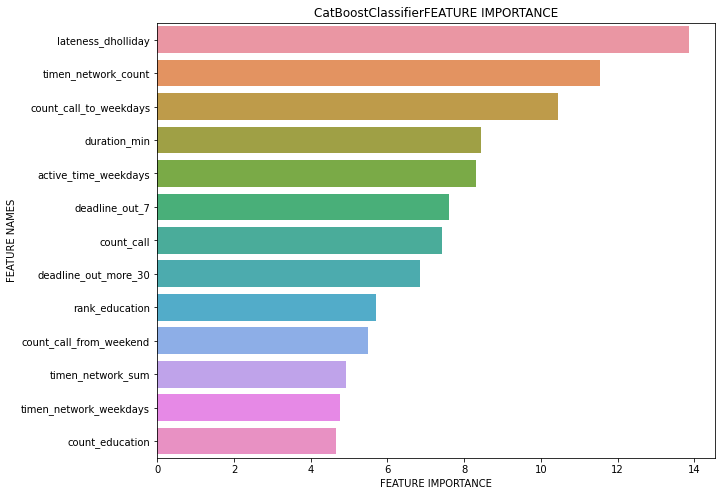

In [235]:
plot_feature_importance(model.get_feature_importance(), features_train.columns, 'CatBoostClassifier')

In [264]:
features_test = test.drop(['type', 
                             'id',
                            'is_staff_id',
                             'active_time_weekdend',
                             'timen_network_weekend',
                             'lateness_dwork',
                             'deadline_ok',
                             'duration_weekend',
                             'deadline_out_30',
                           'duration_weekdays',
                            'duration_max', 
#                              'duration_min',
                             'duration_call_to','duration_call_from',
                           'count_call_to','count_call_from',
#                              'count_call_to_weekdays',
#                              'count_call_from_weekend',
                           'deadline_out_7',
#                              'active_time_weekdays',
#                            'timen_network_count',
#                            'timen_network_sum',
#                             'duration_min', 
                           'duration_sum',
#                            'count_education',
#                          'rank_education', 
#                            'lateness_dholliday',
                          ], axis=1)
print(features_test.shape)

(262, 12)


In [267]:
preds = model.predict(features_test)

test["type"] = preds

df_submission = test[['id', 'type']]

df_submission['type']

C:\Users\User\AppData\Local\Temp/ipykernel_40224/2511319663.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["type"] = preds


550    3
551    2
552    1
553    0
554    2
      ..
807    2
808    0
809    0
810    2
811    1
Name: type, Length: 262, dtype: int64

In [268]:
df_submission.to_csv("sub.csv", index=False)